<a href="https://colab.research.google.com/github/federicocampo/CNN_prova/blob/Prime_modifiche/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the dataset from Google Drive

In [30]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Setting a personal logger and a streamHandler

In [31]:
import time
import logging

#Setting a logger and a logging level
logger = logging.getLogger('Mylogger')
logger.setLevel(logging.DEBUG)
#Setting an handler to send logging output
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
#Set the format of every log message printing the name of logger, logging level and the message.
formatter = logging.Formatter('%(name)s (%(levelname)s): %(message)s')
ch.setFormatter(formatter)
#Add the specified handler to this logger.
logger.addHandler(ch)

# Read and visualize the original dataset

In [3]:
from matplotlib import pyplot as plt
from skimage.io import imread, imshow
import os
import glob
import numpy as np

In [4]:
PATH = 'gdrive/MyDrive/IMAGES/Mammography_micro'

*Imread* returns a 60 x 60 array

In [5]:
import multiprocessing as mp

def read_img(image_path):
  '''Takes as input the path to the image folder and 
  returns the numpy array of images and label found in that folder'''

  #Creating a list of all image names found in image_path
  fnames = glob.glob(os.path.join(image_path, '*.pgm'))

  #Defining 4 sub-processes and apply imread to all the images found previously
  #(imread reads images in pgm format)
  pool = mp.Pool(processes=4)
  results = pool.map_async(imread, fnames)

  #Get the list of images and convert to numpy array
  x = results.get()
  x_np = np.array(x, dtype='float32')[..., np.newaxis]/255

  logger.info('Num images found in %s: %d',image_path, len(x_np))

  #Create a list of corrisponding labels and conver it to numpy array
  label = os.path.basename(image_path)
  y = [int(label)] * len(x_np)
  y_np = np.array(y)

  
  return x_np, y_np


In [6]:
start_time = time.time()

#Define the path to the sub-folder of Train images folder containing "normal" breast mammograms
image_path = os.path.join(PATH, 'Train/0')
#Create the test images and labels array with read_img function
x0_train, y0_train = read_img(image_path)


#Define the path to the sub-folder of Train images folder containing breast mammograms with microcalcifications
image_path = os.path.join(PATH, 'Train/1')
#Create the test images and labels array with read_img function
x1_train, y1_train = read_img(image_path)

#Create an array with both normal and sick images and labels
x_train = np.concatenate((x0_train, x1_train), axis = 0)
y_train = np.concatenate((y0_train, y1_train))

#Doing the same of previous lines, on Test folder
image_path = os.path.join(PATH, 'Test/0')
x0_test, y0_test = read_img(image_path)

image_path = os.path.join(PATH, 'Test/1')
x1_test, y1_test = read_img(image_path)

x_test = np.concatenate((x0_test, x1_test), axis = 0)
y_test = np.concatenate((y0_test, y1_test))

#Print the total number of images found.
print(f'There are {len(x_train)} train images and {len(x_test)} test images')

elapsed_time = time.time() - start_time
logger.debug('Done in %.2f s', elapsed_time)


Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Train/0: 209
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Train/1: 187
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Test/0: 205
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Test/1: 196
Mylogger (DEBUG): Done in 1.44 s


There are 396 train images and 401 test images


Create a single array with both train and test images and an array containing all labels

In [7]:
# Merge train and test in a single array n-dim
X_tot = np.concatenate((x_train, x_test), axis=0)
Y_tot = np.concatenate((y_train, y_test), axis=0)

***Visualize some images***

Visualize n random train images and n random test images 

In [ ]:
import random 

#defining the number of images to visualize
n = 10


#Defining the number or rows and columns of the subplots based on the parity of n
if n % 2 == 0:
  n_rows = n/2
  n_cols = n/2
else: 
  n_rows = int(round(n/2))
  n_cols = int(round(n/2)) +1

#Create the main figure and the subfigures of training images
plt.figure(1, figsize = (15, 15))
plt.suptitle('Train images')
for i in range(1, n+1):
  #Choose a random index among x_train number of images
  r = random.randrange(0, len(x_train))
  Im = x_train[r].squeeze()
  plt.subplot(n_rows, n_cols, i)
  plt.imshow(Im, cmap = 'gray')
  plt.axis('off')
  plt.title(f'{y_train[r]}')

#Create the main figure and the subfigures of test images
plt.figure(2, figsize = (15, 15))
plt.suptitle('Test images')
for i in range(1, n+1):
  r = random.randrange(0, len(x_test))
  Im = x_test[r].squeeze()
  plt.subplot(n_rows, n_cols, i)
  plt.imshow(Im, cmap = 'gray')
  plt.axis('off')
  plt.title(f'{y_test[r]}')


#Data augmentation

##Convert all 'pgm' images format to 'png' format
(needed to run ImageDataGenerator)

In [ ]:
import PIL
import os

In [ ]:
def convert_to_png(fname, dest_folder):
  #Create a new folder to put converted images in
  if not os.path.exists(dest_folder):
    os.makedirs(dest_folder)
    
  logger.debug('converting %s', fname)
  #Change the name of the filename to png extension
  dest_fname = os.path.basename(fname).replace('.pgm', '.png')
  #Define the destination file path
  dest_fname = os.path.join(dest_folder, dest_fname)
  #Convert the image to grayscale and save it
  PIL.Image.open(fname).convert('L').save(dest_fname)

In [ ]:
for data_path in [os.path.join(PATH, "Train"), os.path.join(PATH, "Test")]:
  for path, folders, fnames in os.walk(data_path):
    #Using convert_to_png function to every filename
    for fname in fnames:
      abs_path = os.path.join(path, fname)
      #Create folders for png images at the same path of original pgm images
      dest_folder = path.replace('Train', 'Train_png').replace('Test', 'Test_png')
      convert_to_png(abs_path, dest_folder)


##Data augmentation. 

In [16]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

FLOW_FROM_DIRECTORY takes as input the destination folder path and generates batches of images giving as output an iterator (x, y) where y is the iterator over the labels and x over the images.

Images shape = (batch_size, *target_size, channels) where:

*  batch_size (default = 32) number of images generated from every single x_train image.

Default format of images = png



*  subset = training o validation, funziona solo se c'è validation_split nel 




ImageDataGenerator


IMAGEDATAGENERATOR:
Validation_split = 0.3 divide tutte le N immagini di x_train in: 70% train e 30% validazione e usa questo dataset nel model.fit 


Il.next() accede ad una immagine. train_gen.next()[0] ha shape = (32, 60, 60, 1) cioè per ogni immagine del dataset, lui genera 32 immagini modificate di dimensione 60x60 di colori grayscale

In [17]:
path_to_png_data = os.path.join(PATH, "Train_png")
#Define the shape of the images
img_width, img_height = (60, 60)

aug_validation_split = 0.3


train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2, 
        rescale=1./255,  #Rescale every pixel to have a value between 0 and 1
        shear_range=0.2, #Stretches the image 
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split = validation_split)  
        



train_gen = train_datagen.flow_from_directory(
    path_to_png_data,
    target_size=(img_width, img_height),
    color_mode='grayscale', 
    class_mode='binary',
    subset='training')

val_gen = train_datagen.flow_from_directory(
    path_to_png_data,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    class_mode='binary',
    subset='validation')



Found 278 images belonging to 2 classes.
Found 118 images belonging to 2 classes.


# Defining a CNN model

In [11]:
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, InputLayer, Activation, Dropout
from keras.models import Sequential

In [12]:
def make_model(shape=(60, 60, 1)):
  ''' Returns the CNN model'''
  model = Sequential([
      
      Conv2D(50, (5,5), padding='same', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D((2,2)),
      
      Conv2D(60, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D((2,2)),
        
      Conv2D(100, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),

      Conv2D(100, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),

      Conv2D(50, (4,4), padding='same'),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D(2, 2),

      Flatten(), 
      

      Dense(1, activation='sigmoid')
      
  ])
  
  return model


#Fit model on original dataset

Define a checkpoint to save the best weights of model

In [35]:
from keras.callbacks import ModelCheckpoint

#Set a checkpoint to save weights giving the best performance on val_accuracy 
checkpoint = ModelCheckpoint(
    "model-{epoch:02d}-{val_accuracy:.2f}.hdf5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')


In [36]:
from keras.optimizers import SGD

model = make_model()

model.compile(optimizer = SGD(lr = 0.001, momentum = 0.9), metrics = 'accuracy', loss='binary_crossentropy')

In [ ]:
history = model.fit(x_train, y_train, 
                    validation_split=0.3, 
                    epochs=100, 
                    batch_size=30, 
                    shuffle=True, 
                    callbacks = [checkpoint],
                    verbose=1)

Text(0.5, 1.0, 'Accuracy and val_accuracy')

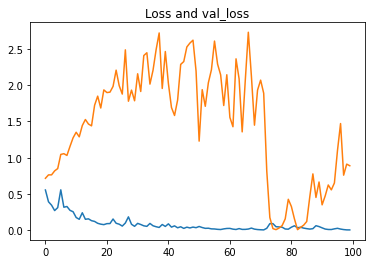

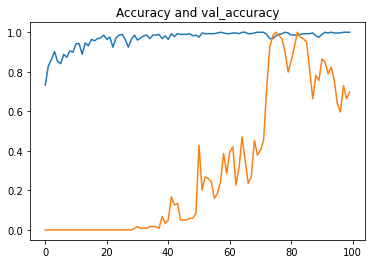

In [38]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss and val_loss')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy and val_accuracy')

In [39]:
model.save(os.path.join(PATH, 'model.hdf5'))
#calculate 'loss' and 'metrics' (accuracy in our case)
model.evaluate(x_test, y_test) 


13/13 [==============================] - 0s 8ms/step - loss: 0.5801 - accuracy: 0.8130


[0.580134391784668, 0.8129675984382629]

# Fit model on augmented dataset

In [24]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "model_augmented.{epoch:02d}-{val_accuracy:.2f}.h5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')


In [25]:
Tot_train_imgs = len(x_train)

In [26]:
from keras.optimizers import SGD


model = make_model()


model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])


batch_size=32
#Defining the number of images to use in each epoch
steps_per_epoch = int(Tot_train_imgs * (1- aug_validation_split))
validation_steps = int(Tot_train_imgs * aug_validation_split)

logger.info('Steps per epoch = %d', steps_per_epoch)
logger.info('Val steps = %d', validation_steps)


history = model.fit(
        train_gen,
        steps_per_epoch = steps_per_epoch // batch_size,
        epochs=100,
        validation_data=val_gen,
        validation_steps= validation_steps // batch_size,
        verbose=1,
        callbacks=[checkpoint])




Mylogger (INFO): Steps per epoch = 277
Mylogger (INFO): Val steps = 118


Epoch 1/100
8/8 [==============================] - 2s 176ms/step - loss: 0.5885 - accuracy: 0.6395 - val_loss: 0.6926 - val_accuracy: 0.4896

Epoch 00001: val_accuracy improved from -inf to 0.48958, saving model to model_augmented.01-0.49.h5
Epoch 2/100
8/8 [==============================] - 1s 132ms/step - loss: 0.5661 - accuracy: 0.6856 - val_loss: 0.6958 - val_accuracy: 0.4792

Epoch 00002: val_accuracy did not improve from 0.48958
Epoch 3/100
8/8 [==============================] - 1s 130ms/step - loss: 0.6183 - accuracy: 0.7142 - val_loss: 0.6943 - val_accuracy: 0.4062

Epoch 00003: val_accuracy did not improve from 0.48958
Epoch 4/100
8/8 [==============================] - 1s 133ms/step - loss: 0.5974 - accuracy: 0.6689 - val_loss: 0.6882 - val_accuracy: 0.7604

Epoch 00004: val_accuracy improved from 0.48958 to 0.76042, saving model to model_augmented.04-0.76.h5
Epoch 5/100
8/8 [==============================] - 1s 132ms/step - loss: 0.5797 - accuracy: 0.6993 - val_loss: 0.7020 -

Visualize the progress of training

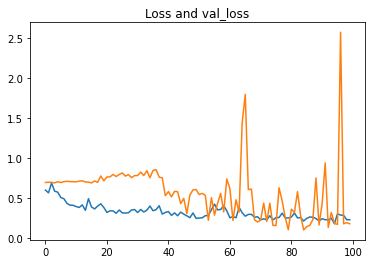

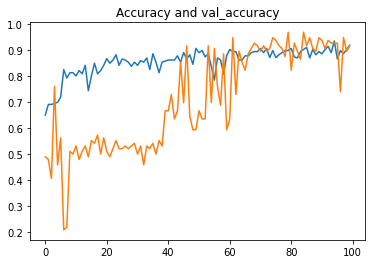

In [27]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss and val_loss')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy and val_accuracy')
plt.show()

Saving the model

In [28]:
model.save(os.path.join(PATH, 'model_augmented.hdf5'))

model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 11ms/step - loss: 0.2911 - accuracy: 0.9177


[0.29110804200172424, 0.9177057147026062]

# Comparing the performances of the two trainings

In [ ]:
from keras.models import load_model
aug_model = load_model(os.path.join(PATH, 'model_augmented.hdf5'))
noaug_model = load_model(os.path.join(PATH, 'model.hdf5'))

In [ ]:
noaug_model.evaluate(x_test, y_test)

aug_model.evaluate(x_test, y_test)

#**Testing model on wavelet-filtered images**

##Define the path and the wavelet type

In [61]:
PATH = 'gdrive/MyDrive/IMAGES/Mammography_micro/Wavelets'

Read the images

In [62]:
print('Wavelet type:')
for i, wavelet_type in enumerate(os.listdir(PATH)):
  print(f'{i}. {wavelet_type}')

Wavelet type:
0. sym2_3levels_nodenoise
1. db2_3levels_nodenoise
2. db5_4levels_nodenoise
3. sym2_3levels_yesdenoise
4. db5_4levels_yesdenoise
5. db2_3levels_yesdenoise


In [63]:
#Choose a wavelet type
wavelet_type = 'db5_4levels_yesdenoise'

##Reading the images applying read_img function

In [64]:
#Define the path to the sub-folder of Train images folder containing "normal" breast mammograms
image_path = os.path.join(PATH, wavelet_type,'Train/0')
#Create the test images and labels array with read_img function
x0_train, y0_train = read_img(image_path)


#Define the path to the sub-folder of Train images folder containing breast mammograms with microcalcifications
image_path = os.path.join(PATH, wavelet_type,'Train/1')
#Create the test images and labels array with read_img function
x1_train, y1_train = read_img(image_path)

#Create an array with both normal and sick images and labels
x_train = np.concatenate((x0_train, x1_train), axis = 0)
y_train = np.concatenate((y0_train, y1_train))

#Doing the same of previous lines, on Test folder
image_path = os.path.join(PATH, wavelet_type, 'Test/0')
x0_test, y0_test = read_img(image_path)

image_path = os.path.join(PATH,  wavelet_type,'Test/1')
x1_test, y1_test = read_img(image_path)

x_test = np.concatenate((x0_test, x1_test), axis = 0)
y_test = np.concatenate((y0_test, y1_test))

#Print the total number of images found.
print(f'There are {len(x_train)} train images and {len(x_test)} test images')

Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Wavelets/db5_4levels_yesdenoise/Train/0: 209
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Wavelets/db5_4levels_yesdenoise/Train/0: 209
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Wavelets/db5_4levels_yesdenoise/Train/1: 187
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Wavelets/db5_4levels_yesdenoise/Train/1: 187
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Wavelets/db5_4levels_yesdenoise/Test/0: 205
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Wavelets/db5_4levels_yesdenoise/Test/0: 205
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Wavelets/db5_4levels_yesdenoise/Test/1: 196
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Wavelets/db5_4levels_yesdenoise/Test/1: 196


There are 396 train images and 401 test images


##Training and eveluate the model

In [42]:
from keras.callbacks import ModelCheckpoint

#Set a checkpoint to save weights giving the best performance on val_accuracy 
checkpoint = ModelCheckpoint(
    "model_on_wavelets-{epoch:02d}-{val_accuracy:.2f}.hdf5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')

In [43]:
from keras.optimizers import SGD

model = make_model()

model.compile(optimizer = SGD(lr = 0.001, momentum = 0.9), metrics = 'accuracy', loss='binary_crossentropy')

In [ ]:
history = model.fit(x_train, y_train, 
                    validation_split=0.3, 
                    epochs=100, 
                    batch_size=30, 
                    shuffle=True, 
                    callbacks = [checkpoint],
                    verbose=1)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [49]:
#calculate 'loss' and 'metrics' (accuracy in our case)
model.evaluate(x_test, y_test) 

13/13 [==============================] - 0s 10ms/step - loss: 3.7141 - accuracy: 0.5312


[3.714081287384033, 0.5311720967292786]

#Implement a cross-validation test

It can be run both for original dataset loaded in the second block and for wavelet-filtered dataset loaded in the block above this.

In [65]:
from sklearn.model_selection import KFold
from keras.optimizers import SGD

In [ ]:
# Define per-fold accuracy and loss arrays
acc_per_fold = []
loss_per_fold = []

#Define the number of folds to split dataset on
num_folds = 10

kfold = KFold(n_splits = num_folds, shuffle=True)

batch_size = 32
num_epochs = 50

fold_num = 1

#Define the model and compile
model = make_model()
model.compile(optimizer=SGD(lr = 0.001, momentum = 0.9), metrics = 'accuracy', loss='binary_crossentropy')
#Saving the weights before training as reset before each training
model.save_weights('reset_model.h5')

for train, test in kfold.split(X_tot, Y_tot):
  #Reset the model loading weights of untrained model
  model.load_weights('reset_model.h5')
  #Fitting the model using every folder but one as training
  history = model.fit(
          X_tot[train], Y_tot[train],
          batch_size = batch_size,
          verbose=0,
          epochs = num_epochs)  
  
  #Evaluate the efficiency of the model
  scores = model.evaluate(X_tot[test], Y_tot[test], verbose=0)

  print('In folder {:d}: {} of {:.4f} - {} of {:.4f}'.format(fold_num,
                                                          model.metrics_names[0],scores[0],
                                                          model.metrics_names[1], scores[1] ))
  plt.figure(fold_num)
  plt.suptitle(f'In fold num. {fold_num}')
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'])
  #plt.plot(history.history['val_loss'])
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'])
  #plt.plot(history.history['val_accuracy'])

  acc_per_fold.append(scores[1])
  loss_per_fold.append(scores[0])
  fold_num += 1

Computing average scores

In [ ]:
print('Average scores for all folds:')
print(f'-- Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
#Calculare loss error as maximum value error
err_loss = (max(loss_per_fold)-min(loss_per_fold))/2
print(f'-- Loss: {np.mean(loss_per_fold)} +/- {err_loss}')
